In [30]:
!pip3 install vaderSentiment

In [31]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from nltk.cluster import KMeansClusterer,cosine_distance, euclidean_distance
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

In [32]:
!pip3 install spacy-transformers

In [33]:
!python3 -m spacy download en_trf_bertbaseuncased_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [34]:
import spacy
import pandas as pd

In [35]:
nlp=spacy.load('/usr/local/lib/python3.6/dist-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')

Let's test it to see if it's working well.

In [36]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # 0.73428553
print(apple1[0].similarity(apple3[0]))  # 0.43365782

0.73428565
0.43365785


In [37]:
reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/reviews_and_ratings.csv')

In [38]:
reviews_ratings.head(2)

,overall,reviewText
0,1,I was a huge fan when the Divergent series sta...
1,4,Excellent read.


In [39]:
reviews_ratings.shape

(5535445, 2)

In [40]:
#Let's just take the first 10_000 rows to test for feasibility.
reviews_ratings_selection=reviews_ratings.loc[:1_000_000]

In [41]:
reviews_ratings.dropna(inplace=True)

In [42]:
#parameters for tokenization
max_len=200
training_samples=600_000
validation_samples=100_000
max_words=10_000

In [43]:
#instantiate the tokenizer
tokenizer=Tokenizer(num_words=max_words)

In [44]:
text_data=reviews_ratings_selection['reviewText'].astype('str')

In [45]:
#fit the tokenizer
tokenizer.fit_on_texts(text_data)

In [46]:
#create the sequences
sequences=tokenizer.texts_to_sequences(text_data)

In [47]:
#pad sequences
data=pad_sequences(sequences,maxlen=max_len) #to be able to handle docs too small to feed.

In [48]:
#y is rating (here referred to as 'overall')
y=reviews_ratings_selection['overall']

In [49]:
#create train/test sets
X_train=data[:training_samples]
X_test=data[training_samples:training_samples+validation_samples]

y_train=y[:training_samples]
y_train_categorical=tf.keras.utils.to_categorical(y_train)[:,1:]  #dropping first column
y_train_categorical[:4]
y_test=y[training_samples:training_samples+validation_samples]
y_test_categorical=tf.keras.utils.to_categorical(y_test)[:,1:]  #dropping first column
y_test_categorical[:100]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [50]:
y_test[90:100]

600090    5
600091    5
600092    5
600093    5
600094    4
600095    5
600096    4
600097    3
600098    5
600099    5
Name: overall, dtype: int64

Thus, ratings 1,2,3,4,5 correspond to labels 0,1,2,3,4 respectively.

In [51]:
#simple network model
#model=Sequential()
#model.add(Dense(64,activation='relu'))
#model.add(Dense(1,activation='linear'))

In [74]:
#test architecture
model=Sequential([
    layers.Input(shape=(200, )),
    layers.BatchNormalization(),
    layers.Dense(1500,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(4500,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(9000,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(450,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(125,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(50,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(25,activation='relu',kernel_regularizer=l2(0)),
    layers.Dense(5,activation='softmax')
])

In [75]:
#compile
model.compile(
    loss='categorical_crossentropy',
    optimizer='Rmsprop', #'Adadelta',  #keras.optimizers.Adam(lr=0.00001),
    metrics=['accuracy']
)

In [76]:
#Let's perform value_count on reviews_ratings_selection by 'overall'. This will help us compute appropriate class weights for each class.
reviews_ratings_selection['overall'].value_counts(normalize=True)

5    0.668561
4    0.180189
3    0.076424
1    0.038292
2    0.036534
Name: overall, dtype: float64

In [77]:
class_weight = {4: 20,
                3: 1,
                2: 2,
                0: 3,
                1: 4}

In [78]:
#fit
history=model.fit(X_train,y_train_categorical,batch_size=10000,class_weight=class_weight,validation_data=(X_test,y_test_categorical),epochs=20,verbose=1)

Epoch 1/20
60/60 [==============================] - 173s 3s/step - loss: 17.2248 - accuracy: 0.6495 - val_loss: 2.6029 - val_accuracy: 0.6673
Epoch 2/20
60/60 [==============================] - 172s 3s/step - loss: 4.1703 - accuracy: 0.6724 - val_loss: 2.0683 - val_accuracy: 0.6673
Epoch 3/20
60/60 [==============================] - 171s 3s/step - loss: 3.7446 - accuracy: 0.6724 - val_loss: 1.8261 - val_accuracy: 0.6673
Epoch 4/20
60/60 [==============================] - 171s 3s/step - loss: 3.4847 - accuracy: 0.6724 - val_loss: 1.7983 - val_accuracy: 0.6673
Epoch 5/20
60/60 [==============================] - 172s 3s/step - loss: 3.3463 - accuracy: 0.6724 - val_loss: 1.8128 - val_accuracy: 0.6673
Epoch 6/20
60/60 [==============================] - 171s 3s/step - loss: 3.3040 - accuracy: 0.6724 - val_loss: 1.6123 - val_accuracy: 0.6673
Epoch 7/20
60/60 [==============================] - 172s 3s/step - loss: 3.2804 - accuracy: 0.6724 - val_loss: 1.5759 - val_accuracy: 0.6673
Epoch 8/20
6

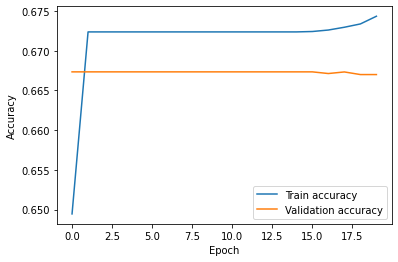

In [79]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='Train accuracy')   #mae on training set
plt.plot(history.history['val_accuracy'],label='Validation accuracy');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

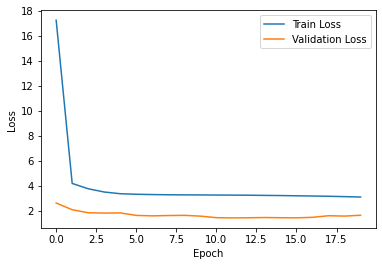

In [80]:
plt.plot(history.history['loss'],label='Train Loss')   #mae on training set
plt.plot(history.history['val_loss'],label='Validation Loss');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [81]:
preds=model.predict(X_test)

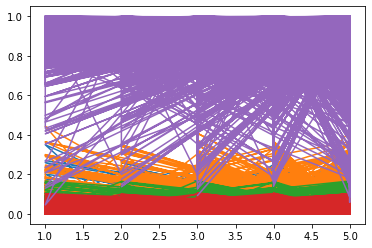

In [82]:
plt.plot(y_test,preds)

In [85]:
pd.DataFrame(preds).value_counts()

0             1             2             3         4       
9.717498e-04  1.118222e-03  2.177022e-03  0.006344  0.989389    697
9.748152e-04  1.121453e-03  2.182289e-03  0.006351  0.989370    422
9.764369e-04  1.123156e-03  2.185061e-03  0.006355  0.989360    411
1.000279e-03  1.148189e-03  2.225746e-03  0.006412  0.989213    389
9.802184e-04  1.127135e-03  2.191538e-03  0.006364  0.989337    358
                                                               ... 
5.840972e-03  6.407804e-03  7.867383e-03  0.009237  0.970647      1
5.841059e-03  6.384223e-03  7.967177e-03  0.009583  0.970225      1
5.841073e-03  6.390168e-03  7.932461e-03  0.009463  0.970374      1
5.841104e-03  6.408894e-03  7.864129e-03  0.009226  0.970660      1
7.874573e-09  2.395073e-08  1.954512e-07  0.000008  0.999991      1
Length: 90656, dtype: int64

In [84]:
pd.DataFrame(y_test).describe()

,overall
count,100000.000000
mean,4.407550
std,1.028146
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000
